In [1]:
import scanpy as sc
import pandas as pd
import celltypist
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from celltypist import models
from utils import sankey_plot_with_labels

RANDOM_STATE = 42
RESULTS_FOLDER = 'results/'
DATA_PATH = 'data/GSE239626/MTX'

c:\Users\giuli\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read_10x_mtx(
    DATA_PATH,
    var_names='gene_symbols',
    gex_only=False,
    cache=True)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 72317 × 36636
    var: 'gene_ids', 'feature_types'

In [3]:
adata = adata[:, adata.var['feature_types'] == 'Gene Expression']

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
labels = pd.read_csv(RESULTS_FOLDER+'cluster_labels.csv', index_col=0)
adata.obs['protein_cluster'] = labels['leiden']
adata

AnnData object with n_obs × n_vars = 72317 × 36601
    obs: 'protein_cluster'
    var: 'gene_ids', 'feature_types'
    uns: 'log1p'

In [6]:
labels['leiden'].head()

AAACCCAAGACTGTTC-1    6
AAACCCAAGGATCATA-1    3
AAACCCAGTTATTCTC-1    8
AAACCCATCATGAGGG-1    3
AAACGAAAGCCAGTAG-1    2
Name: leiden, dtype: int64

### Model

In [7]:
models.download_models(force_update=False)

📂 Storing models in C:\Users\giuli\.celltypist\data\models
⏩ Skipping [1/46]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/46]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/46]: Adult_CynomolgusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [4/46]: Adult_Human_PancreaticIslet.pkl (file exists)
⏩ Skipping [5/46]: Adult_Human_Skin.pkl (file exists)
⏩ Skipping [6/46]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [7/46]: Adult_Mouse_OlfactoryBulb.pkl (file exists)
⏩ Skipping [8/46]: Adult_Pig_Hippocampus.pkl (file exists)
⏩ Skipping [9/46]: Adult_RhesusMacaque_Hippocampus.pkl (file exists)
⏩ Skipping [10/46]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [11/46]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [12/46]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [13/46]: Cells_Adult_Breast.pkl (file exists)
⏩ Skipping [14/46]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [15/46]: Cells_Human_Tonsil.pkl (file exists)
⏩ Skipping [16/46]: Cells_Intestinal_Tract

In [8]:
model_name = 'Immune_All_High'
model = models.Model.load(model = model_name+'.pkl')

In [9]:
predictions = celltypist.annotate(
    adata,
    over_clustering=labels['leiden'].tolist(),
    model = model_name+'.pkl',
    majority_voting=True,
    mode='best match'
)

🔬 Input data has 72317 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [10]:
predictions.predicted_labels.head()

,predicted_labels,over_clustering,majority_voting
AAACCCAAGACTGTTC-1,T cells,6,T cells
AAACCCAAGGATCATA-1,T cells,3,T cells
AAACCCAGTTATTCTC-1,B cells,8,B cells
AAACCCATCATGAGGG-1,T cells,3,T cells
AAACGAAAGCCAGTAG-1,B cells,2,B cells


In [11]:
sum(predictions.predicted_labels['over_clustering']==labels['leiden']) / len(labels['leiden'])

1.0

In [12]:
predictions.predicted_labels.to_csv(RESULTS_FOLDER+'celltypist_labels_from_protein_'+model_name+'.csv')

### Results

In [13]:
len(predictions.predicted_labels['predicted_labels'].unique())

19

In [14]:
labels_str = [str(label) for label in labels['leiden']]

In [15]:
sankey_plot_with_labels( labels=[labels_str, predictions.predicted_labels['predicted_labels']], labels_titles=['Protein cluster', 'Cell Type'],
    title='', width=700, height=450)

In [16]:
adata.obs['predicted_labels'] = predictions.predicted_labels['predicted_labels']

In [17]:
clustering_score_df = pd.read_csv(RESULTS_FOLDER+'clustering_score.csv')

row = clustering_score_df[clustering_score_df['silhouette_score'] == clustering_score_df['silhouette_score'].max()]
n_neighbors = row['n_neighbors'].values[0]
resolution = row['resolution'].values[0]
pca_dim = row['pca_dim'].values[0]

sc.pp.neighbors(
    adata,
    n_neighbors=n_neighbors,
    n_pcs=pca_dim,
    knn=True,
    metric='euclidean', # 'correlation'
    random_state=RANDOM_STATE
    )

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'feature_types' as categorical


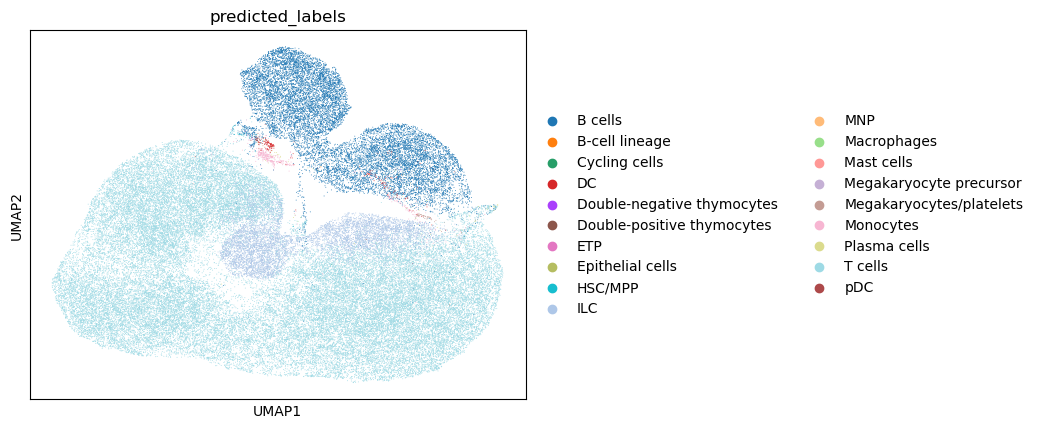

In [18]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['predicted_labels'], color_map='tab20')

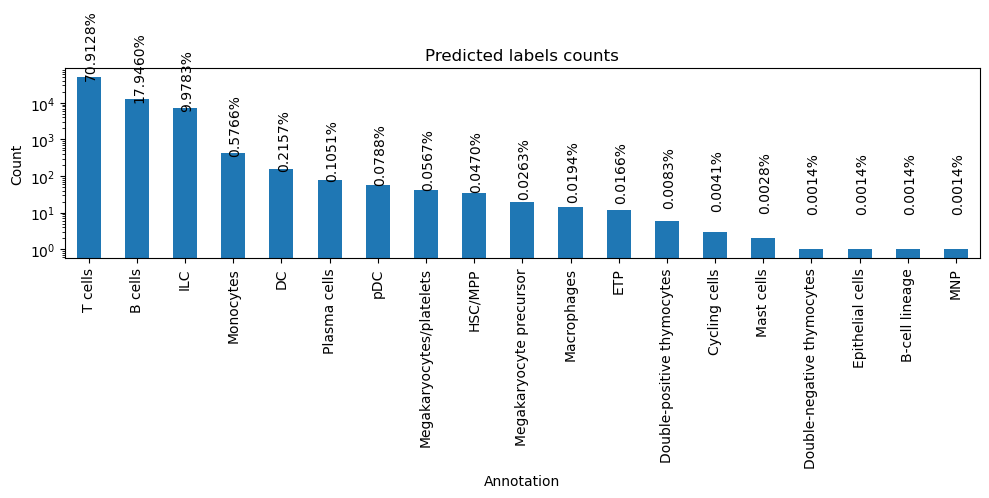

In [19]:
plt.figure(figsize=(10, 5))
ax = plt.gca()
adata.obs['predicted_labels'].value_counts().plot(kind='bar', ax=ax)
total= len(adata.obs['predicted_labels'])
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height() + 10
    plt.annotate(percentage, (x, y), rotation=90)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Predicted labels counts')
plt.xlabel('Annotation')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [20]:
labels = adata.obs['predicted_labels'].value_counts()[adata.obs['predicted_labels'].value_counts() > 1].index
adata = adata[adata.obs['predicted_labels'].isin(labels)]
sc.tl.rank_genes_groups(adata, groupby='predicted_labels', method='t-test')
gene_groups = adata.uns['rank_genes_groups']

In [21]:
markers = {}
for label in predictions.predicted_labels['predicted_labels'].unique():
    if label in labels:
        markers[label] = gene_groups['names'][label].tolist()[:50] # top 50 markers, for each cell type

print(markers)

{'T cells': ['IL7R', 'BCL11B', 'TRAC', 'CD3D', 'CD3G', 'CD3E', 'FYB1', 'IL32', 'TCF7', 'PRKCQ-AS1', 'LEF1', 'CAMK4', 'AAK1', 'RCAN3', 'SERINC5', 'TRABD2A', 'PDE3B', 'LEPROTL1', 'LDHB', 'CD2', 'TRAT1', 'LIME1', 'MAL', 'NOSIP', 'CD6', 'INPP4B', 'OXNAD1', 'PAG1', 'CD28', 'PRKCA', 'CD8B', 'FAM153CP', 'CHRM3-AS2', 'ITK', 'THEMIS', 'LINC00861', 'CD27', 'SPOCK2', 'TC2N', 'GIMAP7', 'RGS10', 'NELL2', 'IL6ST', 'TRBC2', 'PIK3IP1', 'AQP3', 'TNFRSF25', 'LCK', 'FLT3LG', 'PCED1B-AS1'], 'B cells': ['MS4A1', 'CD74', 'HLA-DRA', 'IGHM', 'HLA-DQB1', 'BANK1', 'HLA-DRB1', 'RALGPS2', 'LINC00926', 'CD79A', 'HLA-DPB1', 'CD37', 'MEF2C', 'MARCH1', 'HLA-DQA1', 'HLA-DPA1', 'CD79B', 'HLA-DMB', 'IGKC', 'AFF3', 'HLA-DRB5', 'TNFRSF13C', 'IGHD', 'BCL11A', 'STX7', 'CD22', 'HLA-DMA', 'ADAM28', 'NIBAN3', 'SWAP70', 'NCF1', 'TCF4', 'PAX5', 'IRF8', 'POU2F2', 'CIITA', 'FCRL1', 'COBLL1', 'P2RX5', 'ARHGAP24', 'FCER2', 'BLK', 'HVCN1', 'SNX2', 'TCL1A', 'ITPR1', 'SEL1L3', 'FCRL2', 'VPREB3', 'LINC02397'], 'ILC': ['GNLY', 'PRF1', 'K

In [22]:
with open(RESULTS_FOLDER+'celltypist_markers_from_protein_'+model_name+'.json', 'w') as f:
    json.dump(markers, f)

In [23]:
markers_restricted_10 = {}
for label in predictions.predicted_labels['predicted_labels'].unique():
    if label in labels:
        markers_restricted_10[label] = gene_groups['names'][label].tolist()[:10] # top 10 markers, for each cell type

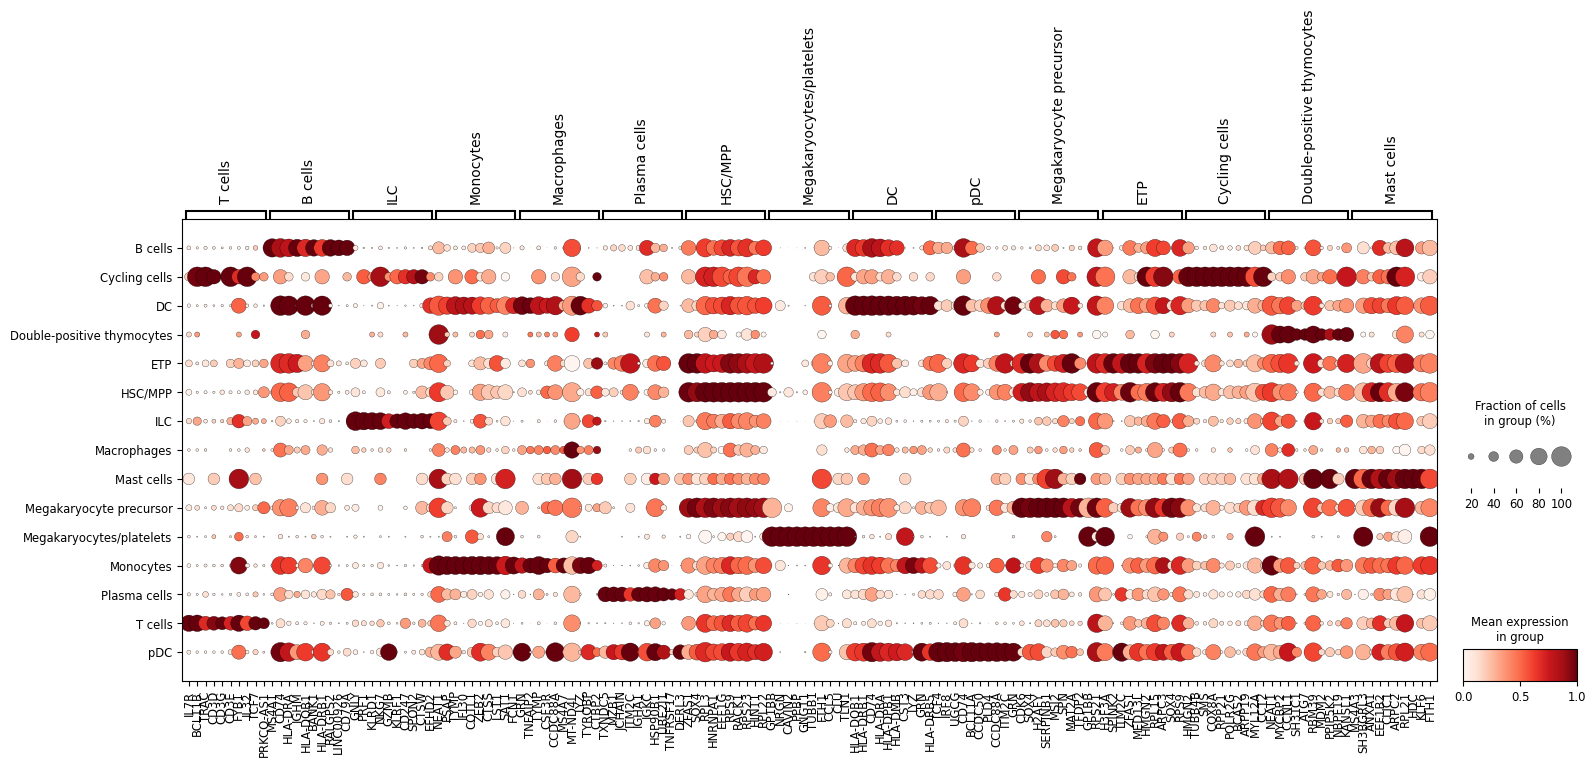

In [24]:
sc.pl.dotplot(
    adata,
    markers_restricted_10,
    groupby="predicted_labels",
    figsize=(18, 6),
    standard_scale='var',
)

In [26]:
markers_restricted_5 = {}
for label in predictions.predicted_labels['predicted_labels'].unique():
    if label in labels:
        markers_restricted_5[label] = gene_groups['names'][label].tolist()[:5] # five markers for each cell type

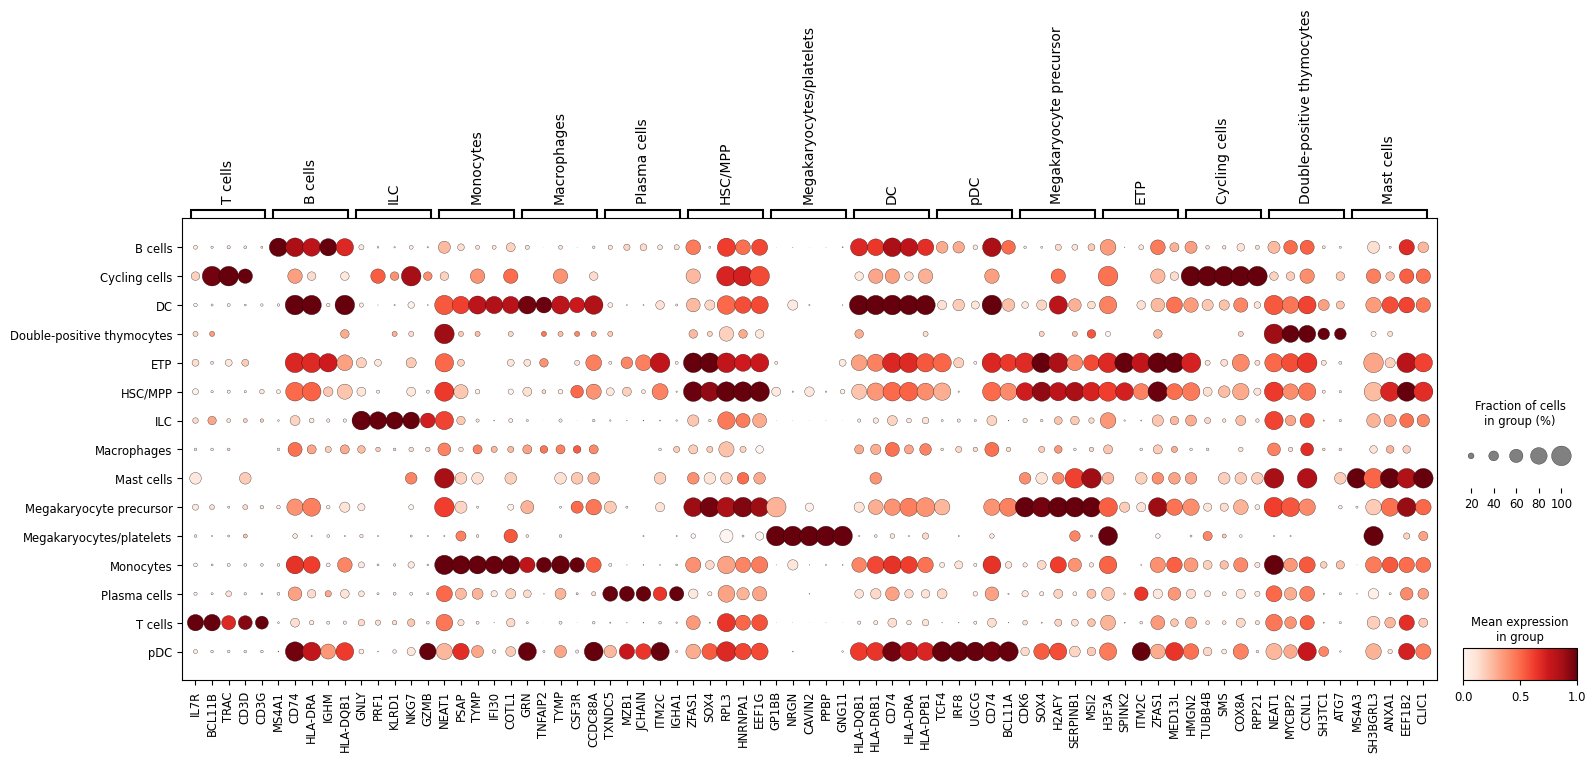

In [27]:
sc.pl.dotplot(
    adata,
    markers_restricted_5,
    groupby="predicted_labels",
    figsize=(18, 6),
    standard_scale='var',
)